<a href="https://colab.research.google.com/github/sujikathir/Sales-Forecasting/blob/main/Arima_Model_for_Sales_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#1.Load the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fbprophet
%matplotlib inline
import datetime
import plotly

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 2.Load the data
data=pd.read_csv('/content/drive/MyDrive/Sales Dataset 2020.csv')

In [ ]:
# 3.Convert the column name (ID) into index
df=data.set_index('ID',drop= True)
df.head()

,Item No.,May-17,Jun-17,Jul-17,Aug-17,Sep-17,Oct-17,Nov-17,Dec-17,Jan-18,Feb-18,Mar-18,Apr-18,May-18,Jun-18,Jul-18,Aug-18,Sep-18,Oct-18,Nov-18,Dec-18,Jan-19,Feb-19,Mar-19,Apr-19,May-19,Jun-19,Jul-19,Aug-19,Sep-19,Oct-19,Nov-19,Dec-19,Jan-20,Feb-20,Mar-20,Apr-20,May-20,Q2-2017,Q3-2017,Q4-2017,Q1-2018,Q2-2018,Q3-2018,Q4-2018,Q1-2019,Q2-2019,Q3-2019,Q4-2019,Q1-2020,Q2-2020,Year-2017,Year-2018,Year-2019,Year-2020,Total Sales,Category
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2613,10697,1081.00000000,150,4013,2251,4059,6176,2744.00000000,2667,2668,2331,3695.00000000,3999,3539.00000000,2457.00000000,5605.00000000,1226.00000000,2712.00000000,3434.00000000,767.00000000,402.00000000,727.00000000,3574.00000000,200.00000000,102.00000000,204.00000000,2205.00000000,2711,1942,708.00000000,1224.00000000,2101.00000000,1735.00000000,1500.00000000,380.00000000,767.00000000,2000.00000000,826,1231.00000000,10323,11587.00000000,8694.00000000,9995.00000000,9543.00000000,4603.00000000,4501.00000000,2511.00000000,5361.00000000,5060.00000000,2647.00000000,2826.00000000,23141.00000000,32835.00000000,17433.00000000,5473.00000000,78882.00000000,1
4264,14300,67.00000000,11,42,31,90,107,23.00000000,80,29,56,82.00000000,31,114.00000000,32.00000000,100.00000000,76.00000000,50.00000000,35.00000000,102.00000000,20.00000000,4.00000000,10.00000000,60.00000000,3.00000000,30.00000000,77.00000000,83,15,40.00000000,110.00000000,35.00000000,60.00000000,42.00000000,11.00000000,63.00000000,120.00000000,21,78.00000000,163,210.00000000,167.00000000,177.00000000,226.00000000,157.00000000,74.00000000,110.00000000,138.00000000,205.00000000,116.00000000,141.00000000,451.00000000,727.00000000,527.00000000,257.00000000,1962.00000000,0
2747,10922,2.00000000,0,1,8,19,20,34.00000000,36,24,43,26.00000000,31,38.00000000,37.00000000,34.00000000,29.00000000,30.00000000,28.00000000,37.00000000,17.00000000,34.00000000,20.00000000,24.00000000,8.00000000,13.00000000,15.00000000,12,12,21.00000000,12.00000000,13.00000000,16.00000000,11.00000000,7.00000000,6.00000000,7.00000000,2,2.00000000,28,90.00000000,93.00000000,106.00000000,93.00000000,82.00000000,78.00000000,36.00000000,45.00000000,41.00000000,24.00000000,9.00000000,120.00000000,374.00000000,200.00000000,33.00000000,727.00000000,0
2746,10921,2.00000000,2,3,2,5,2,6.00000000,3,6,5,5.00000000,10,2.00000000,4.00000000,8.00000000,6.00000000,5.00000000,3.00000000,10.00000000,6.00000000,6.00000000,5.00000000,2.00000000,1.00000000,4.00000000,7.00000000,7,1,3.00000000,5.00000000,6.00000000,0.00000000,2.00000000,3.00000000,0.00000000,2.00000000,1,4.00000000,10,11.00000000,16.00000000,16.00000000,19.00000000,19.00000000,13.00000000,12.00000000,11.00000000,11.00000000,5.00000000,3.00000000,25.00000000,70.00000000,47.00000000,8.00000000,150.00000000,0
3439,12497,1.00000000,6,102,0,0,0,-2.00000000,337,16,112,8.00000000,9,49.00000000,33.00000000,0.00000000,73.00000000,5.00000000,16.00000000,8.00000000,10.00000000,23.00000000,13.00000000,53.00000000,25.00000000,22.00000000,92.00000000,970,23,65.00000000,16.00000000,110.00000000,62.00000000,9.00000000,87.00000000,8.00000000,14.00000000,1,7.00000000,102,335.00000000,136.00000000,91.00000000,78.00000000,34.00000000,89.00000000,139.00000000,1058.00000000,188.00000000,104.00000000,15.00000000,444.00000000,339.00000000,1474.00000000,119.00000000,2376.00000000,0


In [ ]:
#4. Create a new DataFrame which has only the monthly sales (Quarterly & Yearly sales are excluded)
df1=df.copy()
df1.drop(df1.iloc[:,38:],axis=1,inplace=True)

df1.head()

,Item No.,May-17,Jun-17,Jul-17,Aug-17,Sep-17,Oct-17,Nov-17,Dec-17,Jan-18,Feb-18,Mar-18,Apr-18,May-18,Jun-18,Jul-18,Aug-18,Sep-18,Oct-18,Nov-18,Dec-18,Jan-19,Feb-19,Mar-19,Apr-19,May-19,Jun-19,Jul-19,Aug-19,Sep-19,Oct-19,Nov-19,Dec-19,Jan-20,Feb-20,Mar-20,Apr-20,May-20
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2613,10697,1081.00000000,150,4013,2251,4059,6176,2744.00000000,2667,2668,2331,3695.00000000,3999,3539.00000000,2457.00000000,5605.00000000,1226.00000000,2712.00000000,3434.00000000,767.00000000,402.00000000,727.00000000,3574.00000000,200.00000000,102.00000000,204.00000000,2205.00000000,2711,1942,708.00000000,1224.00000000,2101.00000000,1735.00000000,1500.00000000,380.00000000,767.00000000,2000.00000000,826
4264,14300,67.00000000,11,42,31,90,107,23.00000000,80,29,56,82.00000000,31,114.00000000,32.00000000,100.00000000,76.00000000,50.00000000,35.00000000,102.00000000,20.00000000,4.00000000,10.00000000,60.00000000,3.00000000,30.00000000,77.00000000,83,15,40.00000000,110.00000000,35.00000000,60.00000000,42.00000000,11.00000000,63.00000000,120.00000000,21
2747,10922,2.00000000,0,1,8,19,20,34.00000000,36,24,43,26.00000000,31,38.00000000,37.00000000,34.00000000,29.00000000,30.00000000,28.00000000,37.00000000,17.00000000,34.00000000,20.00000000,24.00000000,8.00000000,13.00000000,15.00000000,12,12,21.00000000,12.00000000,13.00000000,16.00000000,11.00000000,7.00000000,6.00000000,7.00000000,2
2746,10921,2.00000000,2,3,2,5,2,6.00000000,3,6,5,5.00000000,10,2.00000000,4.00000000,8.00000000,6.00000000,5.00000000,3.00000000,10.00000000,6.00000000,6.00000000,5.00000000,2.00000000,1.00000000,4.00000000,7.00000000,7,1,3.00000000,5.00000000,6.00000000,0.00000000,2.00000000,3.00000000,0.00000000,2.00000000,1
3439,12497,1.00000000,6,102,0,0,0,-2.00000000,337,16,112,8.00000000,9,49.00000000,33.00000000,0.00000000,73.00000000,5.00000000,16.00000000,8.00000000,10.00000000,23.00000000,13.00000000,53.00000000,25.00000000,22.00000000,92.00000000,970,23,65.00000000,16.00000000,110.00000000,62.00000000,9.00000000,87.00000000,8.00000000,14.00000000,1


In [ ]:
# 5.Forecasting based on ID
n=int(input("Enter the ID number: "))
ID_monthly_sales_list=(df1.loc[n:n,'May-17':].values.T.flatten())
y=ID_monthly_sales_list.tolist()
print()
print("Monthly sales of ID number",n,"is")
print()
print(y)

Enter the ID number: 4340

Monthly sales of ID number 4340 is

[-32.0, 171.0, 8.0, 0.0, 41.0, 29.0, 265.0, 111.0, 32.0, 72.0, 0.0, 0.0, 80.0, 2.0, 79.0, 1.0, 25.0, 12.0, 50.0, 0.0, 15.0, 0.0, 88.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 12.0, 70.0, 0.0, 0.0, 0.0, 3.0, 0.0, 2.0]


In [ ]:
# 6.Extracting the Month names
months_list=df.iloc[:,1:38].columns
months_list

Index(['May-17', 'Jun-17', 'Jul-17', 'Aug-17', 'Sep-17', 'Oct-17', 'Nov-17',
       'Dec-17', 'Jan-18', 'Feb-18', 'Mar-18', 'Apr-18', 'May-18', 'Jun-18',
       'Jul-18', 'Aug-18', 'Sep-18', 'Oct-18', 'Nov-18', 'Dec-18', 'Jan-19',
       'Feb-19', 'Mar-19', 'Apr-19', 'May-19', 'Jun-19', 'Jul-19', 'Aug-19',
       'Sep-19', 'Oct-19', 'Nov-19', 'Dec-19', 'Jan-20', 'Feb-20', 'Mar-20',
       'Apr-20', 'May-20'],
      dtype='object')

In [ ]:
# 7.To convert May-17 into Date format (YYYY:MM:DD)
def custom_parser(x):
    return datetime.datetime.strptime(x,'%b-%y')


date_lst=[]
for i in range(len(months_list)):
    date_lst.append(custom_parser(months_list[i]))

NOTE:
- The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.

In [ ]:
# 8.Framing new dataframe with months & monthly sales values of the respective ID
new_dataframe=pd.DataFrame(list(zip(date_lst,y)),columns=['ds','y'])
new_dataframe['ds'] = pd.to_datetime(new_dataframe['ds'])
new_dataframe.head()

,ds,y
0,2017-05-01,-32.00000000
1,2017-06-01,171.00000000
2,2017-07-01,8.00000000
3,2017-08-01,0.00000000
4,2017-09-01,41.00000000


In [ ]:
# 9.Importing FBProphet library
from fbprophet import Prophet

In [ ]:
# 10.Importing libraries to use "plotly"
import plotly.offline as py
import plotly.graph_objs as go

In [ ]:
# 11.Fitting the model & Making forecasts
m = Prophet(changepoint_prior_scale=2.5)
m.fit(new_dataframe)
future = m.make_future_dataframe(12,freq='MS')
forecast = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
len(forecast['yhat'])-12


37

In [ ]:
len(forecast['yhat'])

49

In [ ]:
print('RMSE: %f' % np.sqrt(np.mean((forecast.loc[:len(forecast['yhat']), 'yhat']-new_dataframe['y'])**2)) )

RMSE: 24.127305


In [ ]:
# 12.Making all negative values as "0"
x=forecast['yhat']
listed=[]
for i in range(len(x)):
    if x[i]<0:
        x[i]=0
        #listed.append(x)
    #else:x#listed.append(x)
#print(listed)        
        

## 13.Plotting Actual vs Predicted

In [ ]:
py.iplot([
    go.Scatter(x=new_dataframe['ds'], y=new_dataframe['y'], name='Actual'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted'),])
    
    #go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend')
#])

In [ ]:
dff=pd.DataFrame(list(zip(new_dataframe['y'],forecast['yhat'])),columns=['Actual','Predicted'])
dff["MAPE (Mean Absolute Percentage Error)"]=(abs((dff['Actual']-dff['Predicted']))/dff['Actual'])*100
      
dff = dff.apply (pd.to_numeric, errors='coerce') #To drop NaN values

print (dff.dropna(inplace=True))


None


NOTE:
- There are chances that MAPE value could be "infinity",so these values are to be made as "Zero" to find the mean value of the MAPE

In [ ]:
lst=dff['MAPE (Mean Absolute Percentage Error)'].tolist()

for i in range(len(lst)):
    if lst[i]==float('inf'):
        lst[i]=0
    
       
#print(lst)
dff['MAPE (Mean Absolute Percentage Error)']=lst
dff

,Actual,Predicted,MAPE (Mean Absolute Percentage Error)
0,-32.00000000,0.00000000,-100.00000000
1,171.00000000,138.24833900,19.15301813
2,8.00000000,31.63247011,295.40587640
3,0.00000000,2.97762444,0.00000000
4,41.00000000,48.31040127,17.83024701
5,29.00000000,34.95962516,20.55043158
6,265.00000000,236.85674226,10.62009726
7,111.00000000,100.05482686,9.86051635
8,32.00000000,36.62305251,14.44703908
9,72.00000000,62.32922591,13.43163068


In [ ]:
dff['MAPE (Mean Absolute Percentage Error)'].mean()

152.4841484481219

In [ ]:
dff['MAPE (Mean Absolute Percentage Error)'].mean()/dff['MAPE (Mean Absolute Percentage Error)'].count()

4.484827895532997

In [ ]:
dff['MAPE (Mean Absolute Percentage Error)'].count()

34

In [ ]:
#import necessary libraries
from sklearn.metrics import mean_squared_error
from math import sqrt

#calculate RMSE
sqrt(mean_squared_error(dff['Actual'],dff['Predicted'])) 



24.629188174600344

In [ ]:
len(dff['Actual']) , len(dff['Predicted'])

(34, 34)

In [ ]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100
mape(dff['Actual'],dff['Predicted'])

inf

In [ ]:
#!pip install PySimpleGUI

In [ ]:
#!pip install PyInstaller

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


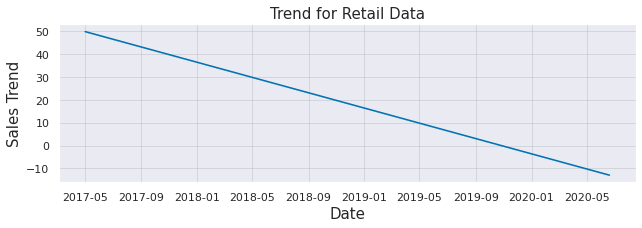

In [ ]:
from fbprophet import Prophet


m = Prophet()
# Selecting one product
#df_store_1 = df_sales[df_sales["Store"]==1]

#df_store_1["Date"] = pd.to_datetime(df_store_1["Date"])
#ds = df_store_1["Date"].dt.tz_localize(None)
#y = df_store_1["Weekly_Sales"]
#df_for_prophet = pd.DataFrame(dict(ds=ds,y=y))
m.fit(new_dataframe)
future = m.make_future_dataframe(periods=49)
forecast = m.predict(future)
forecast = forecast[["ds","trend", "trend_lower", "trend_upper"]]
fig = m.plot_components(forecast,plot_cap=False)
trend_ax = fig.axes[0]
trend_ax.plot()
plt.title("Trend for Retail Data", fontsize=15)
plt.xlabel("Date", fontsize=15)
plt.ylabel("Sales Trend", fontsize=15)

plt.show()

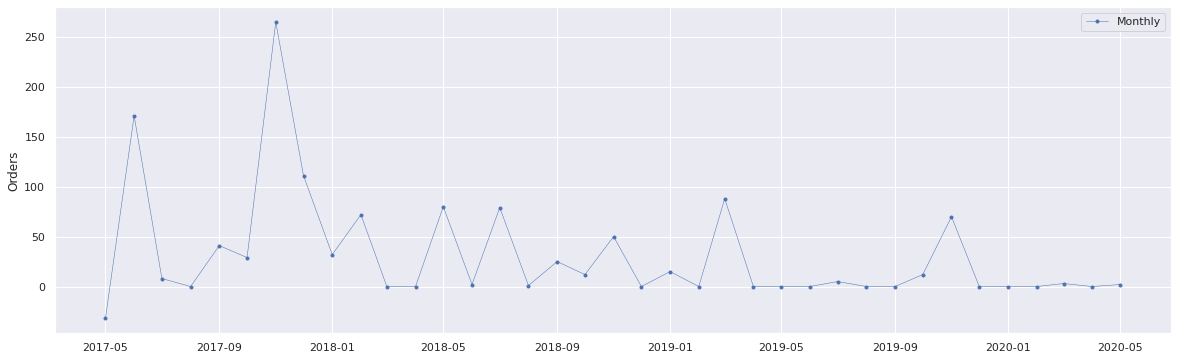

In [ ]:
import warnings
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(new_dataframe['ds'],new_dataframe['y'],marker='.', linestyle='-', linewidth=0.5, label='Monthly')
ax.set_ylabel('Orders')
ax.legend();

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [ ]:
ADF_test(new_dataframe['y'],'raw data')

 > Is the raw data stationary ?
Test statistic = -2.832
P-value = 0.054
Critical values :
	1%: -3.6790595944893187 - The data is not stationary with 99% confidence
	5%: -2.9678817237279103 - The data is not stationary with 95% confidence
	10%: -2.6231583472057074 - The data is  stationary with 90% confidence


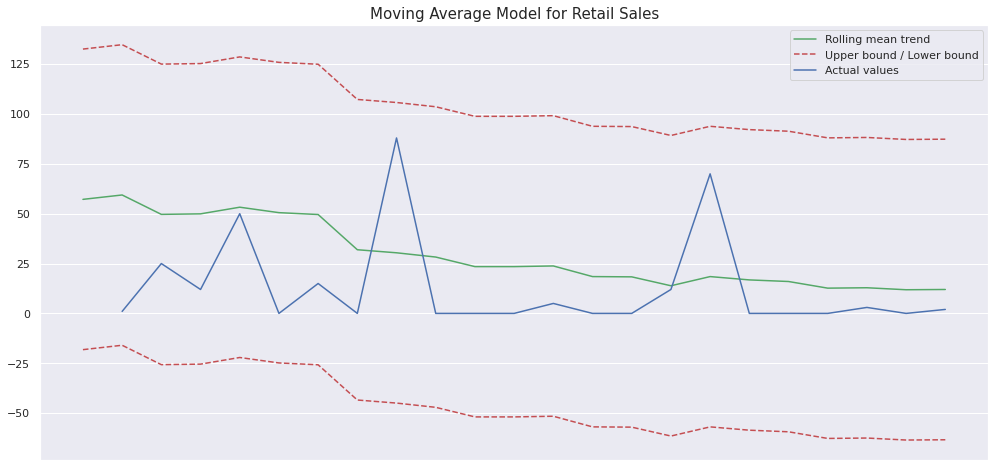

In [ ]:
series = new_dataframe.y
window=15


from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

green = sns.color_palette("deep", 8)[2]
blue = sns.color_palette("deep", 8)[0]

rolling_mean = series.rolling(window=window).mean()
fig,ax = plt.subplots(figsize=(17,8))


plt.title('Moving Average Model for Retail Sales',fontsize=15)

plt.plot(rolling_mean, color = green, label='Rolling mean trend')

#Plot confidence intervals for smoothed values
mae = mean_absolute_error(series[window:], rolling_mean[window:])
deviation = np.std(series[window:] - rolling_mean[window:])
lower_bound = rolling_mean - (mae + 1.92 * deviation)
upper_bound = rolling_mean + (mae + 1.92 * deviation)

plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
plt.plot(lower_bound, 'r--')

plt.plot(series[window:], color=blue,label='Actual values')


plt.legend(loc='best')
plt.grid(True)
plt.xticks([])
plt.show()

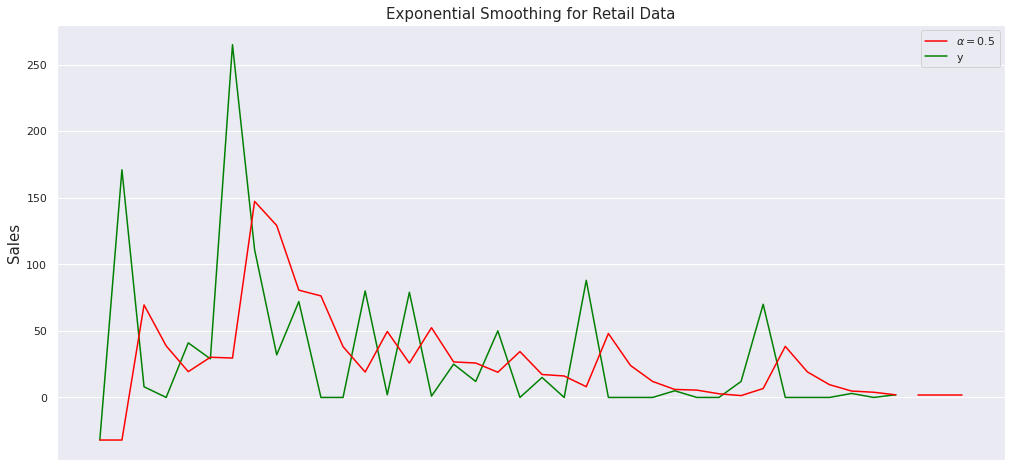

In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set()
import pandas as pd

# Put the correct dataframe here!

fit1 = ExponentialSmoothing(new_dataframe['y'][0:200]).fit(smoothing_level=0.9, optimized=False)

fit2 = ExponentialSmoothing(new_dataframe['y'][0:300]).fit(smoothing_level=0.5, optimized=False)

forecast1 = fit1.forecast(3).rename(r'$\alpha=0.9$')
forecast2 = fit2.forecast(3).rename(r'$\alpha=0.5$')
plt.figure(figsize=(17,8))

#forecast1.plot(color='blue', legend=True)
forecast2.plot(color='red', legend=True)
new_dataframe['y'][0:200].plot(marker='',color='green', legend=True)
plt.ylabel("Sales", fontsize=15)

#fit1.fittedvalues.plot(color='blue')
fit2.fittedvalues.plot(color='red')

plt.title("Exponential Smoothing for Retail Data", fontsize=15)
plt.xticks([], minor=True)
plt.show()

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


X = new_dataframe['y'].values

split = int(0.66*len(X))
train, test = X[0:split], X[split:] 

history = [x for x in train]
predictions = [] 

for t in range(len(test)): 
	model = ARIMA(history, order=(0,0,1))
	model_fit = model.fit(disp=0)

	#future = m.make_future_dataframe(40,freq='MS')
	#forecast = m.predict(future) #change output to forecast
	output = model_fit.forecast(steps=1)
	yhat = output[0] 
	predictions.append(yhat) 
	obs = test[t]
	history.append(obs)
prd_df = new_dataframe.shift(5, axis = 0) 
plt.figure(figsize=(17,8))

# plot predictions and actual values 
#prediction.plot(legend = True) 
#test['y'].plot(legend = True) 
#plt.plot(test)
#plt.plot(predictions, color='red')
#plt.title("ARIMA fit to Sales Data",fontsize=15)
#plt.xticks([])
#py.xlabel('Months')
#plt.ylabel('Sales')
#plt.show()
py.iplot([
    go.Scatter(x=prd_df['ds'], y=history, name='Actual'),
    go.Scatter(x=forecast['ds'], y=test, name='Predicted')])

<Figure size 1224x576 with 0 Axes>

In [ ]:
# To install the library 
!pip install pmdarima 

# Import the library 
from pmdarima import auto_arima 

# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 


In [ ]:

# Fit auto_arima function 
stepwise_fit = auto_arima(new_dataframe['y'], start_p = 1, start_q = 1, 
						max_p = 20, max_q = 20, m = 30, 
						start_P = 0, seasonal = True, 
						d = None, D = 1, trace = True, 
						error_action ='ignore', # we don't want to know if an order does not work 
						suppress_warnings = True, # we don't want convergence warnings 
						stepwise = True)		 # set to stepwise 

# To print the summary 
stepwise_fit.summary() 



Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[30] intercept   : AIC=inf, Time=1.57 sec
 ARIMA(0,0,0)(0,1,0)[30] intercept   : AIC=89.899, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[30] intercept   : AIC=inf, Time=2.14 sec
 ARIMA(0,0,1)(0,1,1)[30] intercept   : AIC=inf, Time=1.38 sec
 ARIMA(0,0,0)(0,1,0)[30]             : AIC=89.575, Time=0.05 sec
 ARIMA(0,0,0)(1,1,0)[30] intercept   : AIC=inf, Time=1.52 sec
 ARIMA(0,0,0)(0,1,1)[30] intercept   : AIC=inf, Time=0.94 sec
 ARIMA(0,0,0)(1,1,1)[30] intercept   : AIC=inf, Time=2.26 sec
 ARIMA(1,0,0)(0,1,0)[30] intercept   : AIC=90.180, Time=0.18 sec
 ARIMA(0,0,1)(0,1,0)[30] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,0,1)(0,1,0)[30] intercept   : AIC=inf, Time=0.42 sec

Best model:  ARIMA(0,0,0)(0,1,0)[30]          
Total fit time: 10.597 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   37
Model:             SARIMAX(0, 1, 0, 30)   Log Likelihood                 -43.788
Date:                  Tue, 12 Jan 2021   AIC                             89.575
Time:                          18:29:30   BIC                             89.521
Sample:                               0   HQIC                            88.907
                                   - 37                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.581e+04   7923.244      1.996      0.046     284.935    3.13e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.86   Jarque-Bera (JB):                 0.49
Prob(Q):                              0.35   Prob(JB):                         0.78
Heteroskedasticity (H):               1.77   Skew:                            -0.57
Prob(H) (two-sided):                  0.72   Kurtosis:                         2.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Split data into train / test sets 
train = new_dataframe.iloc[:len(new_dataframe)-12] 
test = new_dataframe.iloc[len(new_dataframe)-12:] # set one year(12 months) for testing 

# Fit a SARIMAX(0, 1, 1)x(2, 1, 1, 12) on the training set 
from statsmodels.tsa.statespace.sarimax import SARIMAX 

model = SARIMAX(train['y'], 
				order = (0, 0, 0), 
				seasonal_order =(0, 1, 0, 30)) 

result = model.fit() 
result.summary() 


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   25
Model:             SARIMAX(0, 1, 0, 30)   Log Likelihood                   0.000
Date:                  Tue, 12 Jan 2021   AIC                              2.000
Time:                          18:26:06   BIC                                nan
Sample:                               0   HQIC                               nan
                                   - 25                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2          1e-10          0        inf      0.000       1e-10       1e-10
===================================================================================
Ljung-Box (L1) (Q):                    nan   Jarque-Bera (JB):                  nan
Prob(Q):                               nan   Prob(JB):                          nan
Heteroskedasticity (H):                nan   Skew:                              nan
Prob(H) (two-sided):                   nan   Kurtosis:                          nan
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

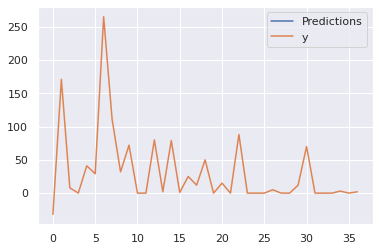

In [ ]:
start = len(train) 
end = len(train) + len(test) + 5

# Predictions for one-year against the test set 
predictions = result.predict(start, end, 
							typ = 'levels').rename("Predictions") 

# plot predictions and actual values 
predictions.plot(legend = True) 
new_dataframe['y'].plot(legend = True) 





In [ ]:
data = series.values
import pmdarima as pm 
stepwise_model = pm.auto_arima(data, start_p=1, start_q=1,
                               max_p=20, max_q=20, m=30,
                               start_P=0, seasonal=True,
                               d=1, D=1, trace=True,
                               error_action='ignore',  
                               suppress_warnings=True, 
                               stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[30]             : AIC=inf, Time=1.75 sec
 ARIMA(0,1,0)(0,1,0)[30]             : AIC=80.078, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[30]             : AIC=inf, Time=1.87 sec
 ARIMA(0,1,1)(0,1,1)[30]             : AIC=inf, Time=1.15 sec
 ARIMA(0,1,0)(1,1,0)[30]             : AIC=inf, Time=1.35 sec
 ARIMA(0,1,0)(0,1,1)[30]             : AIC=inf, Time=0.53 sec
 ARIMA(0,1,0)(1,1,1)[30]             : AIC=83.806, Time=1.96 sec
 ARIMA(1,1,0)(0,1,0)[30]             : AIC=80.424, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[30]             : AIC=80.441, Time=0.14 sec
 ARIMA(1,1,1)(0,1,0)[30]             : AIC=81.861, Time=0.34 sec
 ARIMA(0,1,0)(0,1,0)[30] intercept   : AIC=81.165, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,1,0)[30]          
Total fit time: 9.289 seconds
80.07762073482596


In [ ]:
pred = np.vstack(predictions)
prediction = np.vstack(pred)
flattened_list = [y for x in prediction for y in x]
print(flattened_list)

[17.916440003335584, 12.822192173216578, 8.469601440085953, 5.308418987250468, 2.214294203033894, -0.6262624779481591, -1.8483509706453987, 3.289100942834949, 2.8938190752976767, 0.4977485674636344, -1.614374193582588, -3.219925345491581, -4.814371555688956]


In [ ]:
import numpy as np

EPSILON = 1e-10


def _error(actual: np.ndarray, predicted: np.ndarray):
    """ Simple error """
    return actual - predicted


def _percentage_error(actual: np.ndarray, predicted: np.ndarray):
    """
    Percentage error
    Note: result is NOT multiplied by 100
    """
    return _error(actual, predicted) / (actual + EPSILON)


def _naive_forecasting(actual: np.ndarray, seasonality: int = 1):
    """ Naive forecasting method which just repeats previous samples """
    return actual[:-seasonality]


def _relative_error(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """ Relative Error """
    if benchmark is None or isinstance(benchmark, int):
        # If no benchmark prediction provided - use naive forecasting
        if not isinstance(benchmark, int):
            seasonality = 1
        else:
            seasonality = benchmark
        return _error(actual[seasonality:], predicted[seasonality:]) /\
               (_error(actual[seasonality:], _naive_forecasting(actual, seasonality)) + EPSILON)

    return _error(actual, predicted) / (_error(actual, benchmark) + EPSILON)


def _bounded_relative_error(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """ Bounded Relative Error """
    if benchmark is None or isinstance(benchmark, int):
        # If no benchmark prediction provided - use naive forecasting
        if not isinstance(benchmark, int):
            seasonality = 1
        else:
            seasonality = benchmark

        abs_err = np.abs(_error(actual[seasonality:], predicted[seasonality:]))
        abs_err_bench = np.abs(_error(actual[seasonality:], _naive_forecasting(actual, seasonality)))
    else:
        abs_err = np.abs(_error(actual, predicted))
        abs_err_bench = np.abs(_error(actual, benchmark))

    return abs_err / (abs_err + abs_err_bench + EPSILON)


def _geometric_mean(a, axis=0, dtype=None):
    """ Geometric mean """
    if not isinstance(a, np.ndarray):  # if not an ndarray object attempt to convert it
        log_a = np.log(np.array(a, dtype=dtype))
    elif dtype:  # Must change the default dtype allowing array type
        if isinstance(a, np.ma.MaskedArray):
            log_a = np.log(np.ma.asarray(a, dtype=dtype))
        else:
            log_a = np.log(np.asarray(a, dtype=dtype))
    else:
        log_a = np.log(a)
    return np.exp(log_a.mean(axis=axis))


def mse(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Squared Error """
    return np.mean(np.square(_error(actual, predicted)))


def rmse(actual: np.ndarray, predicted: np.ndarray):
    """ Root Mean Squared Error """
    return np.sqrt(mse(actual, predicted))


def nrmse(actual: np.ndarray, predicted: np.ndarray):
    """ Normalized Root Mean Squared Error """
    return rmse(actual, predicted) / (actual.max() - actual.min())


def me(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Error """
    return np.mean(_error(actual, predicted))


def mae(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Absolute Error """
    return np.mean(np.abs(_error(actual, predicted)))


mad = mae  # Mean Absolute Deviation (it is the same as MAE)


def gmae(actual: np.ndarray, predicted: np.ndarray):
    """ Geometric Mean Absolute Error """
    return _geometric_mean(np.abs(_error(actual, predicted)))


def mdae(actual: np.ndarray, predicted: np.ndarray):
    """ Median Absolute Error """
    return np.median(np.abs(_error(actual, predicted)))


def mpe(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Percentage Error """
    return np.mean(_percentage_error(actual, predicted))


def mape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Absolute Percentage Error
    Properties:
        + Easy to interpret
        + Scale independent
        - Biased, not symmetric
        - Undefined when actual[t] == 0
    Note: result is NOT multiplied by 100
    """
    return np.mean(np.abs(_percentage_error(actual, predicted)))


def mdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Median Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.median(np.abs(_percentage_error(actual, predicted)))


def smape(actual: np.ndarray, predicted: np.ndarray):
    """
    Symmetric Mean Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.mean(2.0 * np.abs(actual - predicted) / ((np.abs(actual) + np.abs(predicted)) + EPSILON))


def smdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Symmetric Median Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.median(2.0 * np.abs(actual - predicted) / ((np.abs(actual) + np.abs(predicted)) + EPSILON))


def maape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Arctangent Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.mean(np.arctan(np.abs((actual - predicted) / (actual + EPSILON))))


def mase(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    """
    Mean Absolute Scaled Error
    Baseline (benchmark) is computed with naive forecasting (shifted by @seasonality)
    """
    return mae(actual, predicted) / mae(actual[seasonality:], _naive_forecasting(actual, seasonality))


def std_ae(actual: np.ndarray, predicted: np.ndarray):
    """ Normalized Absolute Error """
    __mae = mae(actual, predicted)
    return np.sqrt(np.sum(np.square(_error(actual, predicted) - __mae))/(len(actual) - 1))


def std_ape(actual: np.ndarray, predicted: np.ndarray):
    """ Normalized Absolute Percentage Error """
    __mape = mape(actual, predicted)
    return np.sqrt(np.sum(np.square(_percentage_error(actual, predicted) - __mape))/(len(actual) - 1))


def rmspe(actual: np.ndarray, predicted: np.ndarray):
    """
    Root Mean Squared Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.sqrt(np.mean(np.square(_percentage_error(actual, predicted))))


def rmdspe(actual: np.ndarray, predicted: np.ndarray):
    """
    Root Median Squared Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.sqrt(np.median(np.square(_percentage_error(actual, predicted))))


def rmsse(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    """ Root Mean Squared Scaled Error """
    q = np.abs(_error(actual, predicted)) / mae(actual[seasonality:], _naive_forecasting(actual, seasonality))
    return np.sqrt(np.mean(np.square(q)))


def inrse(actual: np.ndarray, predicted: np.ndarray):
    """ Integral Normalized Root Squared Error """
    return np.sqrt(np.sum(np.square(_error(actual, predicted))) / np.sum(np.square(actual - np.mean(actual))))


def rrse(actual: np.ndarray, predicted: np.ndarray):
    """ Root Relative Squared Error """
    return np.sqrt(np.sum(np.square(actual - predicted)) / np.sum(np.square(actual - np.mean(actual))))


def mre(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """ Mean Relative Error """
    return np.mean(_relative_error(actual, predicted, benchmark))


def rae(actual: np.ndarray, predicted: np.ndarray):
    """ Relative Absolute Error (aka Approximation Error) """
    return np.sum(np.abs(actual - predicted)) / (np.sum(np.abs(actual - np.mean(actual))) + EPSILON)


def mrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """ Mean Relative Absolute Error """
    return np.mean(np.abs(_relative_error(actual, predicted, benchmark)))


def mdrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """ Median Relative Absolute Error """
    return np.median(np.abs(_relative_error(actual, predicted, benchmark)))


def gmrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """ Geometric Mean Relative Absolute Error """
    return _geometric_mean(np.abs(_relative_error(actual, predicted, benchmark)))


def mbrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """ Mean Bounded Relative Absolute Error """
    return np.mean(_bounded_relative_error(actual, predicted, benchmark))


def umbrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """ Unscaled Mean Bounded Relative Absolute Error """
    __mbrae = mbrae(actual, predicted, benchmark)
    return __mbrae / (1 - __mbrae)



METRICS = {
    'mse': mse,
    'rmse': rmse,
    'nrmse': nrmse,
    'me': me,
    'mae': mae,
    'mad': mad,
    'gmae': gmae,
    'mdae': mdae,
    'mpe': mpe,
    'mape': mape,
    'mdape': mdape,
    'smape': smape,
    'smdape': smdape,
    'maape': maape,
    'mase': mase,
    'std_ae': std_ae,
    'std_ape': std_ape,
    'rmspe': rmspe,
    'rmdspe': rmdspe,
    'rmsse': rmsse,
    'inrse': inrse,
    'rrse': rrse,
    'mre': mre,
    'rae': rae,
    'mrae': mrae,
    'mdrae': mdrae,
    'gmrae': gmrae,
    'mbrae': mbrae,
    'umbrae': umbrae
}


def evaluate(actual: np.ndarray, predicted: np.ndarray, metrics=('mae', 'mse', 'smape', 'umbrae')):
    results = {}
    for name in metrics:
        try:
            results[name] = METRICS[name](actual, predicted)
        except Exception as err:
            results[name] = np.nan
            print('Unable to compute metric {0}: {1}'.format(name, err))
    return results


def evaluate_all(actual: np.ndarray, predicted: np.ndarray):
    return evaluate(actual, predicted, metrics=set(METRICS.keys()))

evaluate_all(test,predictions)

Unable to compute metric rmdspe: Unable to coerce to Series, length must be 2: given 13
Unable to compute metric me: Unable to coerce to Series, length must be 2: given 13
Unable to compute metric mpe: Unable to coerce to Series, length must be 2: given 13
Unable to compute metric rmsse: Unable to coerce to Series, length must be 2: given 13
Unable to compute metric inrse: Unable to coerce to Series, length must be 2: given 13
Unable to compute metric mase: Unable to coerce to Series, length must be 2: given 13
Unable to compute metric smape: Unable to coerce to Series, length must be 2: given 13
Unable to compute metric mae: Unable to coerce to Series, length must be 2: given 13
Unable to compute metric rmspe: Unable to coerce to Series, length must be 2: given 13
Unable to compute metric smdape: Unable to coerce to Series, length must be 2: given 13
Unable to compute metric rmse: Unable to coerce to Series, length must be 2: given 13
Unable to compute metric umbrae: Unable to coerce 

{'gmae': nan,
 'gmrae': nan,
 'inrse': nan,
 'maape': nan,
 'mad': nan,
 'mae': nan,
 'mape': nan,
 'mase': nan,
 'mbrae': nan,
 'mdae': nan,
 'mdape': nan,
 'mdrae': nan,
 'me': nan,
 'mpe': nan,
 'mrae': nan,
 'mre': nan,
 'mse': nan,
 'nrmse': nan,
 'rae': nan,
 'rmdspe': nan,
 'rmse': nan,
 'rmspe': nan,
 'rmsse': nan,
 'rrse': nan,
 'smape': nan,
 'smdape': nan,
 'std_ae': nan,
 'std_ape': nan,
 'umbrae': nan}

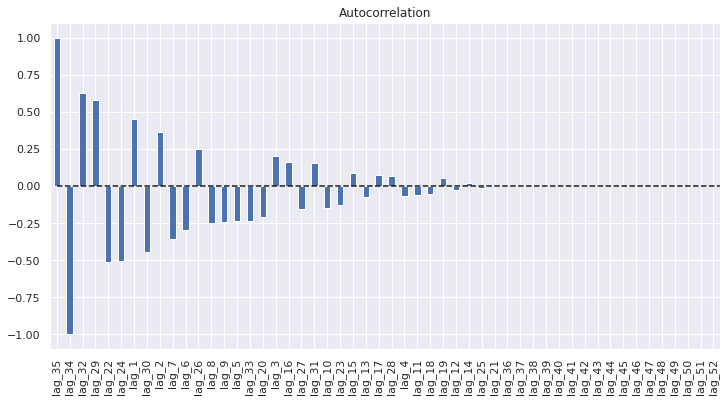

In [ ]:
from sklearn.metrics import mean_squared_error
from pandas import read_csv
from pandas import datetime

# parse dates
def custom_parser(x):
	return datetime.strptime(x, '%b-%y')
 
auto_cor = read_csv('/content/drive/MyDrive/altered sales dataset.csv', header=0, index_col=0, date_parser=custom_parser)

auto_cor = pd.DataFrame(auto_cor)
auto_cor.columns = ["y"]

# Adding the lag of the target variable from 1 steps back up to 52 (due to a seasonality at the end of the year)
for i in range(1, 53):
    auto_cor["lag_{}".format(i)] = auto_cor.y.shift(i)

# Compute autocorrelation of the series and its lags
lag_corr = auto_cor.corr()
lag_corr = lag_corr.iloc[1:,0]
lag_corr.columns = ["corr"]
order = lag_corr.abs().sort_values(ascending = False)
lag_corr = lag_corr[order.index]

# Plot the Autocorrelation
plt.figure(figsize=(12, 6))
lag_corr.plot(kind='bar')
plt.grid(True, axis='y')
plt.title("Autocorrelation")
plt.hlines(y=0, xmin=0, xmax=len(lag_corr), linestyles='dashed')

In [ ]:
data = series.values
import pmdarima as pm 
stepwise_model = pm.auto_arima(data, start_p=1, start_q=1,
                               max_p=20, max_q=20, m=30,
                               start_P=0, seasonal=True,
                               d=1, D=1, trace=True,
                               error_action='ignore',  
                               suppress_warnings=True, 
                               stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[30]             : AIC=inf, Time=1.74 sec
 ARIMA(0,1,0)(0,1,0)[30]             : AIC=80.078, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[30]             : AIC=inf, Time=1.94 sec
 ARIMA(0,1,1)(0,1,1)[30]             : AIC=inf, Time=1.11 sec
 ARIMA(0,1,0)(1,1,0)[30]             : AIC=inf, Time=1.33 sec
 ARIMA(0,1,0)(0,1,1)[30]             : AIC=inf, Time=0.54 sec
 ARIMA(0,1,0)(1,1,1)[30]             : AIC=83.806, Time=1.96 sec
 ARIMA(1,1,0)(0,1,0)[30]             : AIC=80.424, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[30]             : AIC=80.441, Time=0.14 sec
 ARIMA(1,1,1)(0,1,0)[30]             : AIC=81.861, Time=0.34 sec
 ARIMA(0,1,0)(0,1,0)[30] intercept   : AIC=81.165, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,1,0)[30]          
Total fit time: 9.291 seconds
80.07762073482596


In [ ]:
!pip install pmdarima as pm

In [ ]:
# Compute Residual
pred = stepwise_model.predict(n_periods=13)
train_pred = stepwise_model.predict(n_periods=24)
r_train = train - train_pred
r_test = test - pred
residual = pd.DataFrame(np.concatenate((r_train,r_test)), columns={"y"})


# Generate lag of Residuals from 1 step to 52 steps
# Adding the lag of the target variable from 1 steps back up to 52 
for i in range(1, 53):
    residual["lag_{}".format(i)] = residual.y.shift(i)

# Compute correlation of the Residual series and its lags
lag_corr = residual.corr()
lag_corr = lag_corr.iloc[1:,0]
lag_corr.columns = ["corr"]
order = lag_corr.abs().sort_values(ascending = False)
lag_corr = lag_corr[order.index]

# Plot the Residual Autocorrelation
plt.figure(figsize=(12, 6))
lag_corr.plot(kind='bar')
plt.grid(True, axis='y')
plt.title("Autocorrelation")
plt.hlines(y=0, xmin=0, xmax=len(lag_corr), linestyles='dashed')


ValueError: ignored

In [ ]:

# Plot other Criteria (Distribution, Variance, Residual mean)
# Residual mean and Distribution
print("Residual mean: ",residual.iloc[:,0].mean())
plt.hist(residual.iloc[:,0], bins=20)
plt.title("Residual Distribution")


In [ ]:
#Residual variance 
plt.plot(residual.iloc[:,0]) 
plt.title("Residual") 
plt.hlines(y=0, xmin=0, xmax=len(residual), linestyles='dashed')


In [ ]:
# Split train and test sets in correspondence with Time series data
def ts_train_test_split(X, y, test_size):
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [ ]:
def Croston(ts,extra_periods=1,alpha=0.7):
    d = np.array(ts) # Transform the input into a numpy array
    cols = len(d) # Historical period length
    d = np.append(d,[np.nan]*extra_periods) # Append np.nan into the demand array to cover future periods
    
    #level (a), periodicity(p) and forecast (f)
    a,p,f = np.full((3,cols+extra_periods),np.nan)
    q = 1 #periods since last demand observation
    
    # Initialization
    first_occurence = np.argmax(d[:cols]>0)
    a[0] = d[first_occurence]
    p[0] = 1 + first_occurence
    f[0] = a[0]/p[0]
# Create all the t+1 forecasts
    for t in range(0,cols):        
        if d[t] > 0:
            a[t+1] = alpha*d[t] + (1-alpha)*a[t] 
            p[t+1] = alpha*q + (1-alpha)*p[t]
            f[t+1] = a[t+1]/p[t+1]
            q = 1           
        else:
            a[t+1] = a[t]
            p[t+1] = p[t]
            f[t+1] = f[t]
            q += 1
       
    # Future Forecast 
    a[cols+1:cols+extra_periods] = a[cols]
    p[cols+1:cols+extra_periods] = p[cols]
    f[cols+1:cols+extra_periods] = f[cols]
                      
    df = pd.DataFrame.from_dict({"Demand":d,"Forecast":f,"Period":p,"Level":a,"Error":d-f})
    return df
def Croston_TSB(ts,extra_periods=1,alpha=0.4,beta=0.4):
    d = np.array(ts) # Transform the input into a numpy array
    cols = len(d) # Historical period length
    d = np.append(d,[np.nan]*extra_periods) # Append np.nan into the demand array to cover future periods
    
    #level (a), probability(p) and forecast (f)
    a,p,f = np.full((3,cols+extra_periods),np.nan)
# Initialization
    first_occurence = np.argmax(d[:cols]>0)
    a[0] = d[first_occurence]
    p[0] = 1/(1 + first_occurence)
    f[0] = p[0]*a[0]
                 
    # Create all the t+1 forecasts
    for t in range(0,cols): 
        if d[t] > 0:
            a[t+1] = alpha*d[t] + (1-alpha)*a[t] 
            p[t+1] = beta*(1) + (1-beta)*p[t]  
        else:
            a[t+1] = a[t]
            p[t+1] = (1-beta)*p[t]       
        f[t+1] = p[t+1]*a[t+1]
        
    # Future Forecast
    a[cols+1:cols+extra_periods] = a[cols]
    p[cols+1:cols+extra_periods] = p[cols]
    f[cols+1:cols+extra_periods] = f[cols]
                      
    df = pd.DataFrame.from_dict({"Demand":d,"Forecast":f,"Period":p,"Level":a,"Error":d-f})
    return df
def Croston1(ts,extra_periods=1,alpha=0.4):
    d = np.array(ts) # Transform the input into a numpy array
    cols = len(d) # Historical period length
    d = np.append(d,[np.nan]*extra_periods) # Append np.nan into the demand array to cover future periods
    
    #level (a), periodicity(p) and forecast (f)
    a,p,f = np.full((3,cols+extra_periods),np.nan)
    q = 1 #periods since last demand observation
    
    # Initialization
    first_occurence = np.argmax(d[:cols]>0)
    a[0] = d[first_occurence]
    p[0] = 1 + first_occurence
    f[0] = a[0]/p[0]
# Create all the t+1 forecasts
    for t in range(0,cols):        
        if d[t] > 0:
            a[t+1] = alpha*d[t] + (1-alpha)*a[t] 
            p[t+1] = alpha*q + (1-alpha)*p[t]
            f[t+1] = a[t+1]/p[t+1]
            q = 1           
        else:
            a[t+1] = a[t]
            p[t+1] = p[t]
            f[t+1] = f[t]
            q += 1
       
    # Future Forecast 
    a[cols+1:cols+extra_periods] = a[cols]
    p[cols+1:cols+extra_periods] = p[cols]
    f[cols+1:cols+extra_periods] = f[cols]
                      
    df = pd.DataFrame.from_dict({"Demand":d,"Forecast":f,"Period":p,"Level":a,"Error":d-f})
    return df

In [ ]:
Croston1(new_dataframe['y'],extra_periods=1,alpha=0.4)

,Demand,Forecast,Period,Level,Error
0,-32.00000000,85.50000000,2.00000000,171.00000000,-117.50000000
1,171.00000000,85.50000000,2.00000000,171.00000000,85.50000000
2,8.00000000,85.50000000,2.00000000,171.00000000,-77.50000000
3,0.00000000,66.12500000,1.60000000,105.80000000,-66.12500000
4,41.00000000,66.12500000,1.60000000,105.80000000,-25.12500000
5,29.00000000,45.38636364,1.76000000,79.88000000,-16.38636364
6,265.00000000,40.88461538,1.45600000,59.52800000,224.11538462
7,111.00000000,111.27261307,1.27360000,141.71680000,-0.27261307
8,32.00000000,111.17894447,1.16416000,129.43008000,-79.17894447
9,72.00000000,82.34718014,1.09849600,90.45804800,-10.34718014


In [1]:
# grid search ets models for daily female births
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from pandas import read_csv
from numpy import array

# one-step Holt Winter’s Exponential Smoothing forecast
def exp_smoothing_forecast(history, config):
	t,d,s,p,b,r = config
	# define model
	history = array(history)
	model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
	# fit model
	model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	return yhat[0]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = exp_smoothing_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a set of exponential smoothing configs to try
def exp_smoothing_configs(seasonal=[None]):
	models = list()
	# define config lists
	t_params = ['add', 'mul', None]
	d_params = [True, False]
	s_params = ['add', 'mul', None]
	p_params = seasonal
	b_params = [True, False]
	r_params = [True, False]
	# create config instances
	for t in t_params:
		for d in d_params:
			for s in s_params:
				for p in p_params:
					for b in b_params:
						for r in r_params:
							cfg = [t,d,s,p,b,r]
							models.append(cfg)
	return models

if __name__ == '__main__':
	# load dataset
	series = new_dataframe
	data = series.values
	# data split
	n_test = 165
	# model configs
	cfg_list = exp_smoothing_configs()
	# grid search
	scores = grid_search(data[:,0], cfg_list, n_test)
	print('done')
	# list top 3 configs
	for cfg, error in scores[:3]:
		print(cfg, error)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


NameError: ignored